## Reference 보정적용 모델만 autogluon 

- tpot이 훨씬 성능 좋았음.

In [3]:
! pip install autogluon

     ------------------------------------ 224.0/224.0 kB 913.6 kB/s eta 0:00:00
     -------------------------------------- 372.3/372.3 kB 5.8 MB/s eta 0:00:00
     -------------------------------------- 116.3/116.3 kB 1.4 MB/s eta 0:00:00
     -------------------------------------- 285.7/285.7 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 62.1/62.1 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 135.7/135.7 kB 3.9 MB/s eta 0:00:00
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
     ---------------------------------------- 61.1/61.1 kB 1.1 MB/s eta 0:00:00
     --------------------------------------- 21.7/21.7 MB 10.9 MB/s eta 0:00:00
     ---------------------------------------- 3.6/3.6 MB 11.1 MB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 9.1 MB/s eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 4.5 MB/s eta 0:00:00
     ---------------------------------------- 79.3/79.3 kB 4.3 MB/s eta

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [5]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)

top_path = './data/box_img/Top/'
bot_path = './data/box_img/Bot/'

top_path_list = [f'./data/box_img/Top/Top_{i}.jpg' for i in range(0, 127)]
bot_path_list = [f'./data/box_img/Bot/Bot_{i}.jpg' for i in range(0, 127)]

In [6]:
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


- Reference 보정을 위해 기본값을 정하고 Weight를 줘서 보정을 해주면 되지 않을까?

In [7]:
Base_img = np.array(Image.open(top_path_list[0])) #Ref image(bot) 첫번째를 기본 이미지로 지정
Top_transformed_list = []
for i in range(len(bot_path_list)):
    Bot_transformed = np.array(Image.open(bot_path_list[i]))/np.array(Image.open(bot_path_list[0])) #Ref image(bot) i번째를 첫번째로 나누어서 Weight 값 생성
    Top_transformed = np.array(Image.open(top_path_list[i]))*Bot_transformed #Weight 값과 Top image(top) i번째를 곱하여 Weighted image 생성(보정)
    Top_transformed_list.append(Top_transformed) #Weighted image를 리스트에 추가

In [8]:
Top_transformed_list[0].shape

(50, 50, 3)

### AutoML 먼저 시도

In [9]:
top_avg_rgb = []
for i in range(len(Top_transformed_list)):
    top = Top_transformed_list[i]
    Top_R, Top_G, Top_B = np.mean(top[:,:,0]), np.mean(top[:,:,1]), np.mean(top[:,:,2])
    
    top_avg_rgb.append([Top_R, Top_G, Top_B])

In [10]:
top_avg_rgb = np.array(top_avg_rgb)
top_avg_rgb.shape

(127, 3)

In [11]:
#top avg rgb + thickness
Table_dataset = pd.DataFrame(np.concatenate([top_avg_rgb, Thickness], axis = 1), columns=['R', 'G', 'B', 'Thickness'])
Table_dataset

,R,G,B,Thickness
0,11.576000,10.883200,8.136400,48.266667
1,10.826174,11.729849,9.594695,47.966667
2,13.336985,12.112036,8.233817,48.166667
3,9.354297,9.887613,6.912199,48.600000
4,4.799665,2.776091,1.086510,59.533333
...,...,...,...,...
122,0.503564,4.690656,18.853995,84.633333
123,0.825026,14.850428,27.031939,98.366667
124,0.969714,13.035919,33.905851,97.033333
125,1.159944,13.412763,32.316093,96.266667


In [18]:
train_data, test_data = train_test_split(Table_dataset, test_size=0.3, random_state=42)

In [19]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor = TabularPredictor(label='Thickness').fit(train_data)

X_test = test_data.drop(columns=['Thickness'])
y_pred = predictor.predict(X_test)
y_pred.head()

No path specified. Models will be saved in: "AutogluonModels\ag-20230712_130224\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230712_130224\"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   40.24 GB / 510.27 GB (7.9%)
Train Data Rows:    88
Train Data Columns: 3
Label Column: Thickness
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (153.3, 47.96666667, 83.53258, 18.13157)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:      

26     73.983719
111    61.904423
81     73.283188
55     94.770248
44     95.178406
Name: Thickness, dtype: float32

In [20]:
test_data

,R,G,B,Thickness
26,1.483631,0.996422,8.668116,75.533333
111,4.772217,2.498910,0.434744,61.300000
81,0.499675,2.672811,9.141662,68.700000
55,3.734195,19.715681,34.459888,96.633333
44,1.415042,14.238954,31.752100,101.466667
96,3.264495,1.564327,0.585916,63.166667
80,1.085897,2.163926,8.627949,69.433333
125,1.159944,13.412763,32.316093,96.266667
114,2.170149,2.034473,0.809448,61.466667
62,12.869714,29.913734,35.741574,111.533333


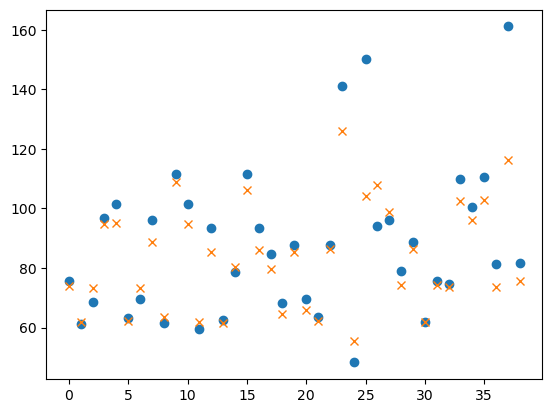

In [26]:
y_test = test_data['Thickness'].values
y_pred = y_pred.values

plt.plot(y_test,'o', label = 'Real')
plt.plot(y_pred,'x', label = 'Predict')

In [28]:
pd.DataFrame({'True': y_test, 'Predict': y_pred})

,True,Predict
0,75.533333,73.983719
1,61.300000,61.904423
2,68.700000,73.283188
3,96.633333,94.770248
4,101.466667,95.178406
5,63.166667,62.282478
6,69.433333,73.152229
7,96.266667,88.812447
8,61.466667,63.530308
9,111.533333,108.893692


In [30]:
mse = np.mean((y_test - y_pred)**2)
mse

135.3665607595131